In [6]:
# Anomaly Detection in Network Traffic using Unsupervised Learning
# Dataset: KDD Cup 1999 (10% corrected sample)
# Models: Isolation Forest & Autoencoder (Improved)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, precision_recall_curve, auc

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ------------------------ Load and Preprocess ------------------------
df = pd.read_csv("kddcup.data_10_percent_corrected", header=None)

columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]
df.columns = columns
df['anomaly'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

df = df.sample(n=10000, random_state=42)
df_encoded = pd.get_dummies(df.drop(['label', 'anomaly'], axis=1), drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)


(10000, 47)
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_ra

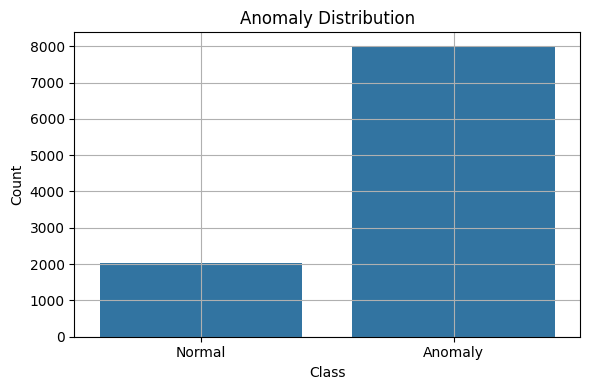

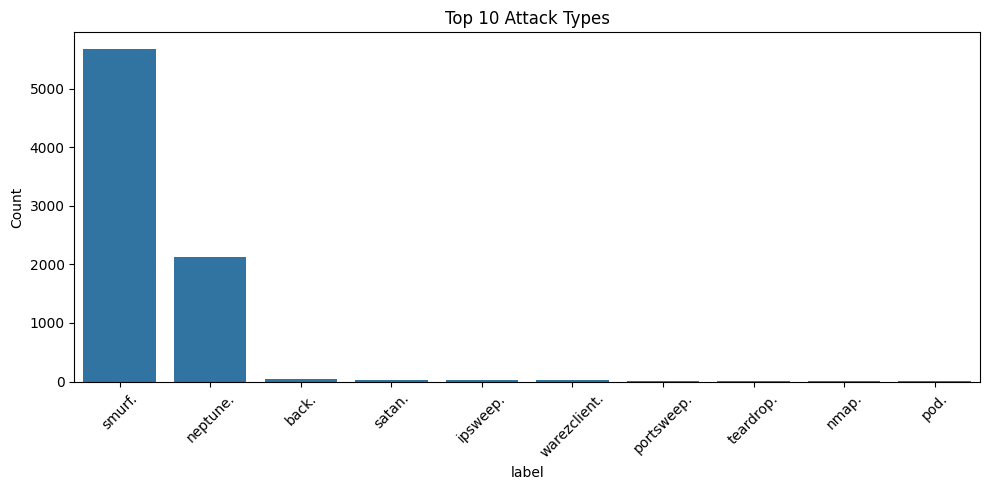

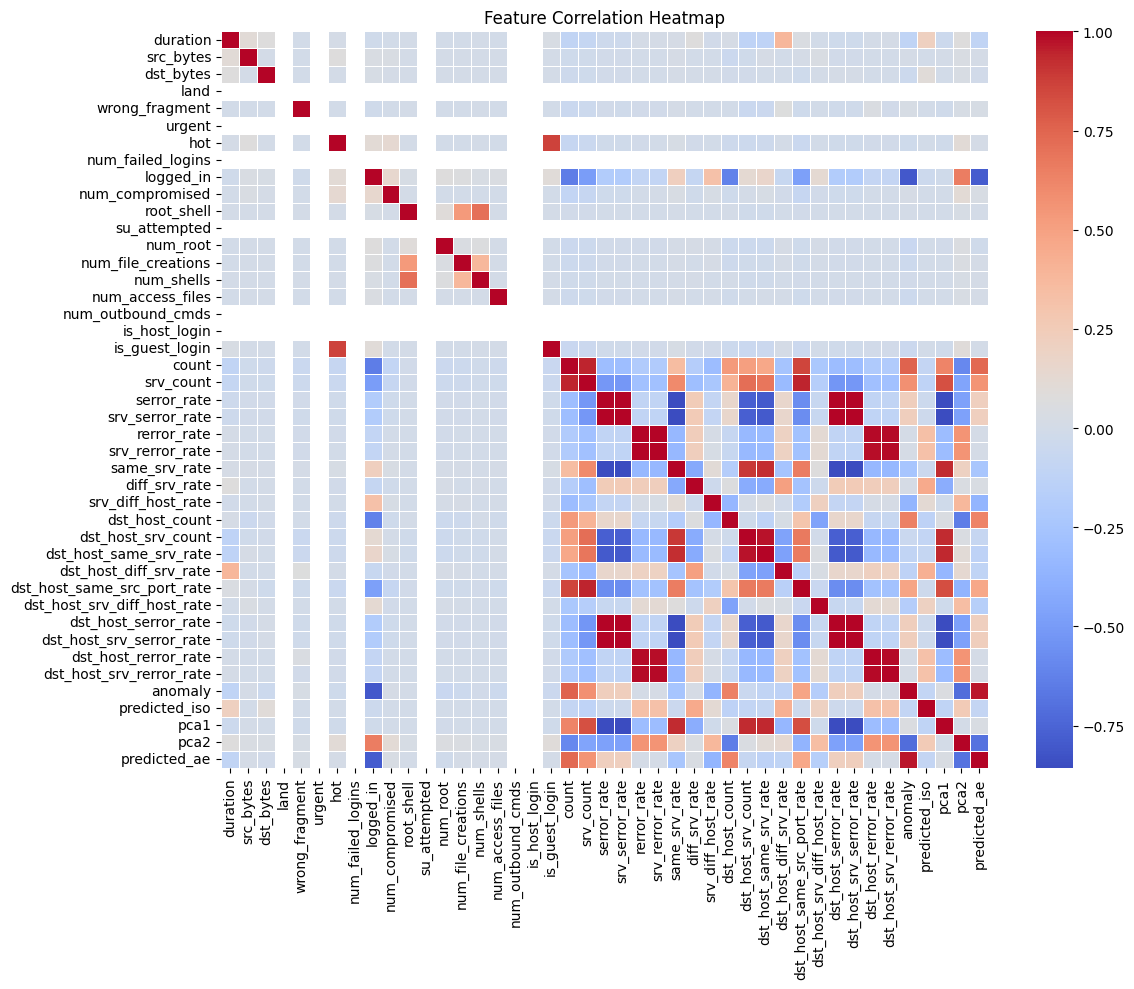

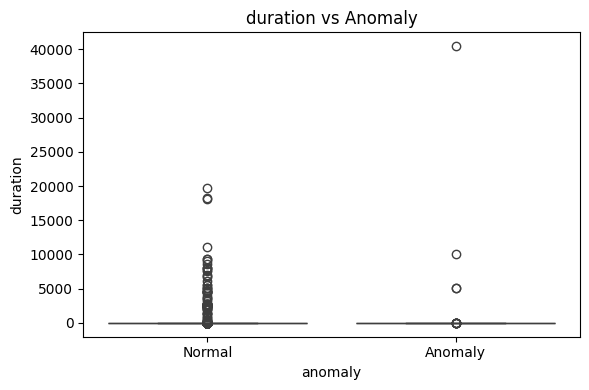

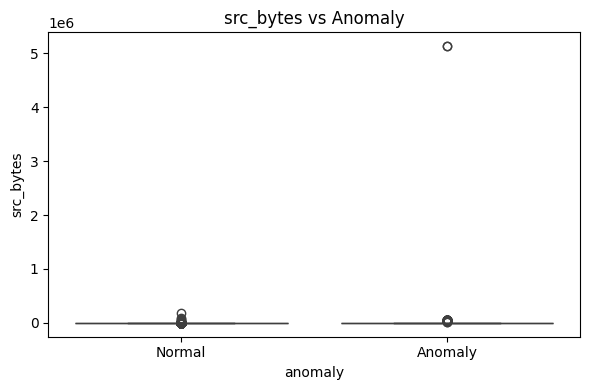

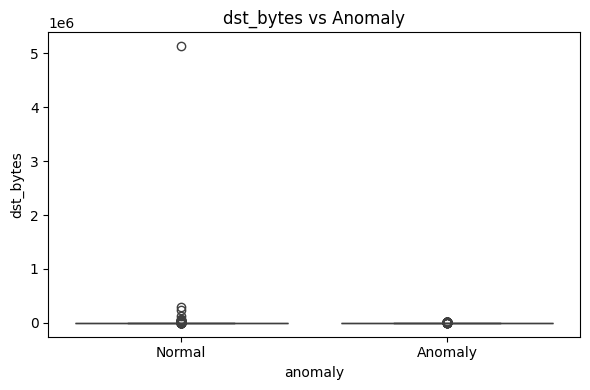

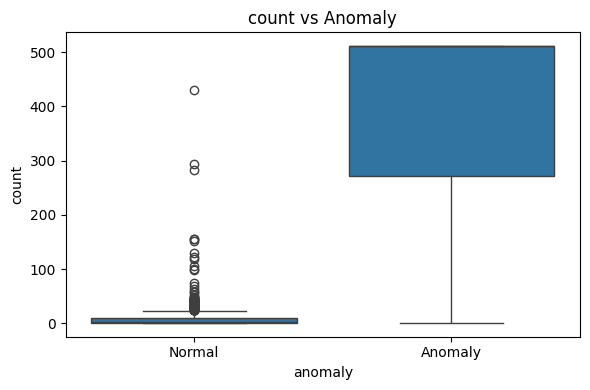

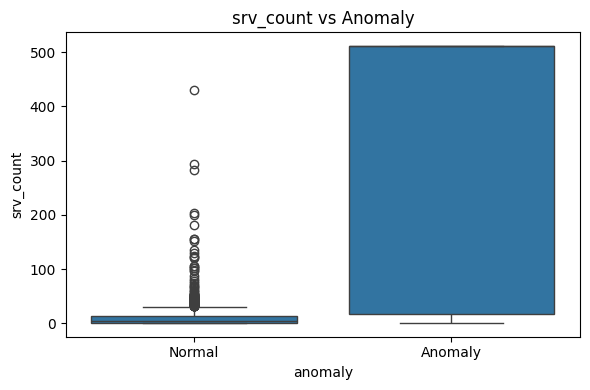

In [8]:
# --- EDA Section ---
#1. Basic Information

print(df.shape)
print(df.dtypes)
print(df['label'].value_counts())
print(df['anomaly'].value_counts())
#2. Attack vs Normal Distribution

plt.figure(figsize=(6,4))
sns.countplot(x='anomaly', data=df)
plt.xticks([0,1], ['Normal', 'Anomaly'])
plt.title("Anomaly Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()
#3. Top 10 Attack Types

top_attacks = df[df['anomaly'] == 1]['label'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_attacks.index, y=top_attacks.values)
plt.title("Top 10 Attack Types")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.tight_layout()
plt.show()
#4. Correlation Heatmap (numeric only)

plt.figure(figsize=(12,10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
#5. Boxplot for a few important features

features = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
for col in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='anomaly', y=col, data=df)
    plt.xticks([0,1], ['Normal', 'Anomaly'])
    plt.title(f"{col} vs Anomaly")
    plt.tight_layout()
    plt.show()

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1975 - val_loss: 1.3908
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8826 - val_loss: 1.2007
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7252 - val_loss: 1.0649
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5939 - val_loss: 0.9647
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5194 - val_loss: 0.9055
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4383 - val_loss: 0.8677
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4084 - val_loss: 0.8330
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3220 - val_loss: 0.8141
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2778 - val_loss: 0.7943
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2583 - val_loss: 0.7723
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2817 - val_loss: 0.7599
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1903 - val_lo

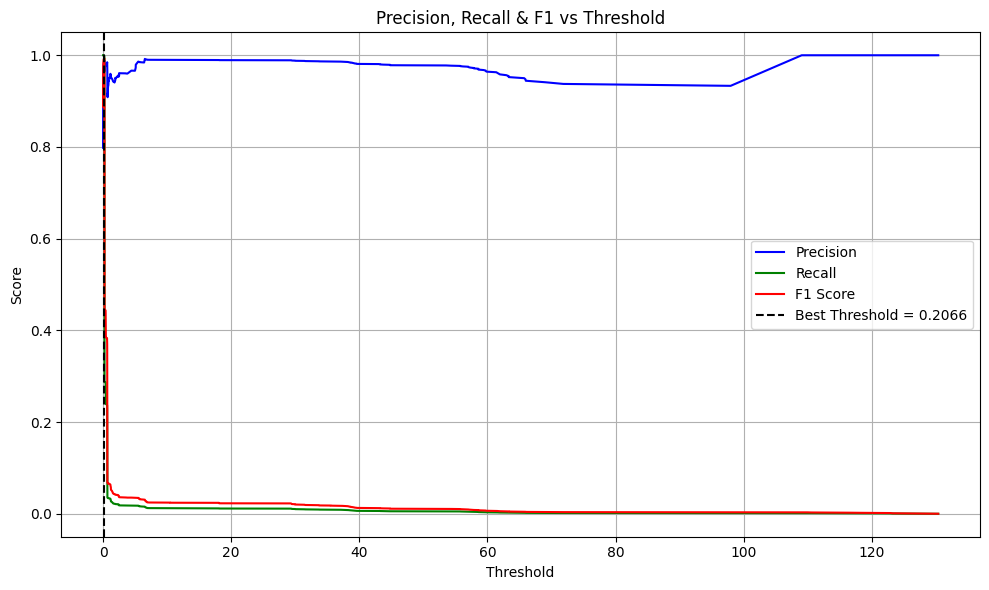

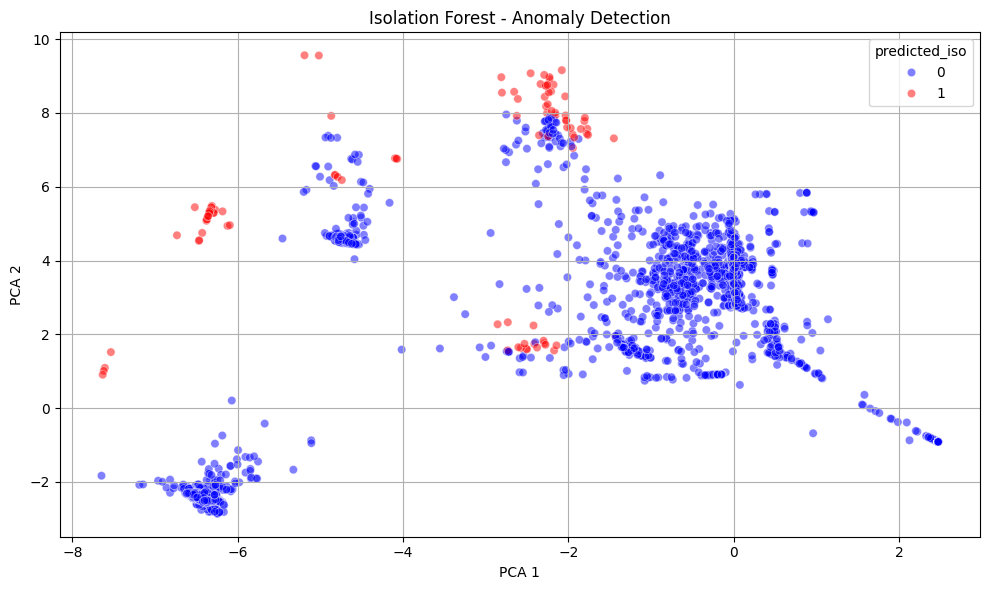

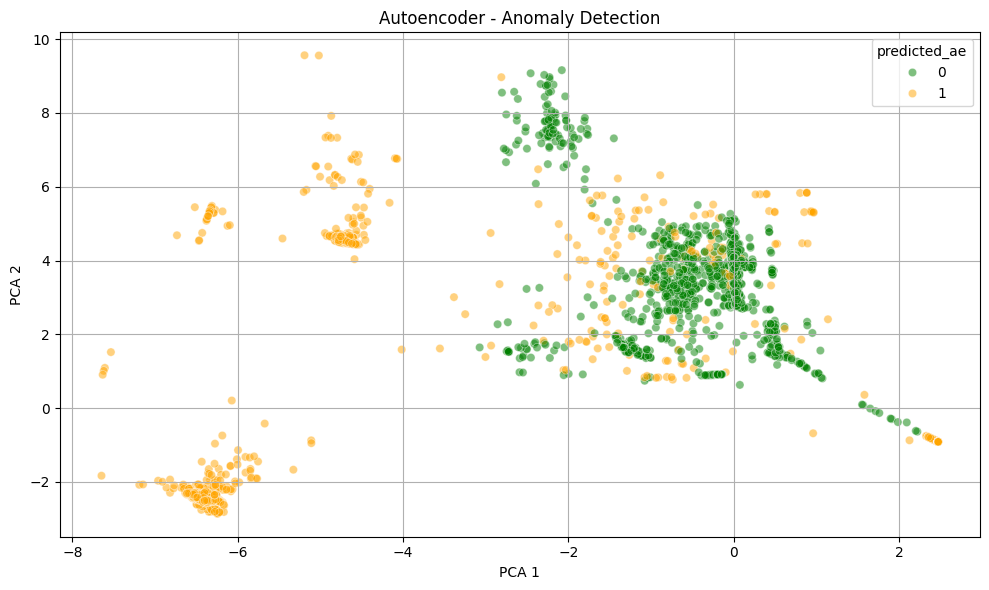


=== Isolation Forest Evaluation ===
predicted_iso
0    9900
1     100
Name: count, dtype: int64
              precision    recall  f1-score   support

           0     0.1978    0.9707    0.3286      2017
           1     0.4100    0.0051    0.0101      7983

    accuracy                         0.1999     10000
   macro avg     0.3039    0.4879    0.1694     10000
weighted avg     0.3672    0.1999    0.0744     10000


=== Autoencoder Evaluation (Threshold = 0.2066) ===
predicted_ae
1    8052
0    1948
Name: count, dtype: int64
              precision    recall  f1-score   support

           0     0.9897    0.9559    0.9725      2017
           1     0.9889    0.9975    0.9932      7983

    accuracy                         0.9891     10000
   macro avg     0.9893    0.9767    0.9829     10000
weighted avg     0.9891    0.9891    0.9890     10000



In [7]:
# ------------------------ Isolation Forest ------------------------
iso_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['predicted_iso'] = iso_model.fit_predict(X_scaled)
df['predicted_iso'] = df['predicted_iso'].map({1: 0, -1: 1})

# ------------------------ PCA for Visualization ------------------------
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['pca1'], df['pca2'] = pca_result[:, 0], pca_result[:, 1]

# ------------------------ Autoencoder ------------------------
X_train = X_scaled[df['anomaly'] == 0]

input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation="relu", activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(32, activation="relu")(encoded)
decoded = Dense(64, activation="relu")(encoded)
output_layer = Dense(input_dim, activation="linear")(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1,
                verbose=1,
                callbacks=[early_stop])

X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - X_pred), axis=1)

# ------------------------ Precision-Recall Curve ------------------------
precision, recall, thresholds = precision_recall_curve(df['anomaly'], reconstruction_error)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

# Plot Precision-Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='green')
plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color='red')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Threshold = {best_threshold:.4f}')
plt.title("Precision, Recall & F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Use the best threshold
df['predicted_ae'] = (reconstruction_error > best_threshold).astype(int)

# ------------------------ Visualizations ------------------------
# Isolation Forest
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='predicted_iso',
                palette={0: 'blue', 1: 'red'}, alpha=0.5)
plt.title("Isolation Forest - Anomaly Detection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Autoencoder
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='predicted_ae',
                palette={0: 'green', 1: 'orange'}, alpha=0.5)
plt.title("Autoencoder - Anomaly Detection")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------ Evaluation ------------------------
print("\n=== Isolation Forest Evaluation ===")
print(df['predicted_iso'].value_counts())
print(classification_report(df['anomaly'], df['predicted_iso'], digits=4))

print("\n=== Autoencoder Evaluation (Threshold = {:.4f}) ===".format(best_threshold))
print(df['predicted_ae'].value_counts())
print(classification_report(df['anomaly'], df['predicted_ae'], digits=4))

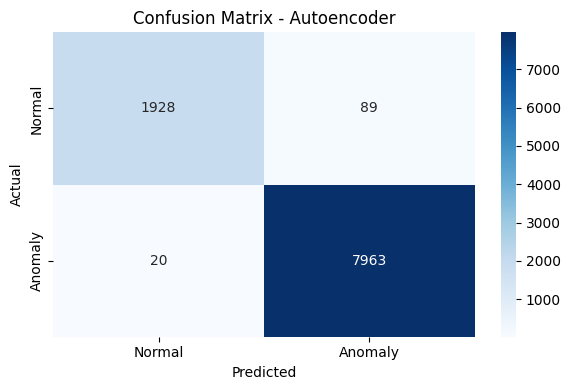

In [9]:
from sklearn.metrics import confusion_matrix

# ------------------------ Confusion Matrix ------------------------
conf_matrix = confusion_matrix(df['anomaly'], df['predicted_ae'])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Anomaly"],
            yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Autoencoder")
plt.tight_layout()
plt.show()


In [3]:
import joblib
autoencoder.save("autoencoder_model.h5")
np.save("reconstruction_error.npy", reconstruction_error)
np.save("true_labels.npy", df['anomaly'].values)
np.save("best_threshold.npy", best_threshold)
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']